# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [30]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "Real", "youtube")
    data_amazon = os.path.join(_data, "Real", "amazon")
    data_dblp = os.path.join(_data, "Real", "dblp")
    data_comlj = os.path.join(_data, "Real", "com-lj")
    
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
    ### Data split
    data_split = os.path.join(_root, "split.json")

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    epochs = 500
    nodes_cnt = 5000
    
    params_drbc = dict(
        # according to source paper
        encoder_params = dict(
            c = 3,
            p = 128,
            num_layers = 5,
            device = device
        ),
        decoder_params = dict(
            p = 128,
            q = 64
        )
    )
    
    params_node2vec = dict(
        in_features = 128
    )

    def __init__(self, d_name):
        # Create dir for train/test

        self.root = os.path.join(self._root, "result", "scales", d_name)
        if os.path.exists(self.root):
            pass
        else:
            os.makedirs(self.root)

        ### Save plt info
        self.train_info_p = os.path.join(self.root, "train.json")
        self.val_info_p = os.path.join(self.root, "valid.json")

        ### Save plt img
        self.result_plt_p = os.path.join(self.root, "train_plt.png")
        
#         self.weight_node2vec = os.path.join(self.root, "node2vec.pth")
        self.weight_drbc = os.path.join(self.root, "drbc.pth")

In [31]:
# date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
date_time = "2021-03-23 00-55"

In [32]:
setting = Setting(d_name=date_time)

In [33]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/scales/2021-03-23 00-55'

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [10]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [11]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [12]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [13]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [14]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [15]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

#### Generate 10,000 for train

In [ ]:
nodes_cnt = setting.nodes_cnt

In [ ]:
train_dir = os.path.join(setting._data, "train", str(nodes_cnt))
if os.path.exists(train_dir):
    pass
else:
    os.makedirs(train_dir)

In [ ]:
for i in range(10000):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(train_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(train_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

#### Generate 100 for validation

In [ ]:
valid_dir = os.path.join(setting._data, "valid", str(nodes_cnt))
if os.path.exists(valid_dir):
    pass
else:
    os.makedirs(valid_dir)

In [ ]:
for i in range(100):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(valid_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(valid_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

## Read data

### Load test data

In [34]:
synthetic, between = load_data(Setting.data_synthetic)
yt, yt_score = load_data(Setting.data_youtube)
amazon, amazon_score = load_data(Setting.data_amazon)
dblp, dblp_score = load_data(Setting.data_dblp)
comlj, comlj_score = load_data(Setting.data_comlj)

In [14]:
train, train_bet = load_data(os.path.join(Setting.data_train, str(Setting.nodes_cnt)))

In [15]:
valid, valid_bet = load_data(os.path.join(Setting.data_valid, str(Setting.nodes_cnt)))

### Cvt to data/dataloader

In [16]:
train_loader = to_dataloader(train, train_bet, batch=16)
valid_loader = to_dataloader(valid, valid_bet, batch=16)

In [35]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [36]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

In [37]:
amazon_loader = to_dataloader(amazon, amazon_score, batch=1, y_sep=":", usecols=1)

In [38]:
dblp_loader = to_dataloader(dblp, dblp_score, batch=1, y_sep=":", usecols=1)

In [39]:
comlj_loader = to_dataloader(comlj, comlj_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [19]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [40]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [41]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [42]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [43]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

# Evaluation

## Top k %

In [44]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [45]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [46]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [47]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

pretrained finded


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [31]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/625 [00:00<?, ?it/s]


Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448998946224, top 1 = 0.914865999999945, top 5 = 0.8922144000000138, top 10 = 0.8814320000000057, kendal = 0.64865252845769


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144892006317, top 1 = 0.9186000000000003, top 5 = 0.8917200000000004, top 10 = 0.8829200000000001, kendal = 0.6491970058011605

Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448820345281, top 1 = 0.9274799999999425, top 5 = 0.9168172000000259, top 10 = 0.9095566000000134, kendal = 0.659534378139628


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448991258538, top 1 = 0.9286, top 5 = 0.917400000000001, top 10 = 0.9098600000000002, kendal = 0.6598574850970195

Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448783850642, top 1 = 0.9343219999999359, top 5 = 0.926428000000008, top 10 = 0.9142880000000098, kendal = 0.6730313558071598


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448769882006, top 1 = 0.9361999999999994, top 5 = 0.9266400000000006, top 10 = 0.9144800000000004, kendal = 0.673086110022004

Epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448737246443, top 1 = 0.9406879999999325, top 5 = 0.9315359999999977, top 10 = 0.9170226000000031, kendal = 0.664307852242449


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931449008682415, top 1 = 0.9421999999999994, top 5 = 0.9316400000000002, top 10 = 0.9165800000000004, kendal = 0.6646268469693938

Epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448762787706, top 1 = 0.9445599999999212, top 5 = 0.9348304000000007, top 10 = 0.9221380000000002, kendal = 0.6461990993238648


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448829871689, top 1 = 0.9461999999999992, top 5 = 0.9339200000000006, top 10 = 0.9220600000000005, kendal = 0.6461963496699339

Epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448665034435, top 1 = 0.9475739999999149, top 5 = 0.9377388000000039, top 10 = 0.9273453999999989, kendal = 0.6390001380916187


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144871608875, top 1 = 0.9493999999999991, top 5 = 0.9368399999999998, top 10 = 0.9270600000000003, kendal = 0.6389159127825564

Epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144863605771, top 1 = 0.9501879999999057, top 5 = 0.9397852000000055, top 10 = 0.9315947999999926, kendal = 0.6717121591518327


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931449029908846, top 1 = 0.9517999999999991, top 5 = 0.9389200000000001, top 10 = 0.9314200000000008, kendal = 0.6715636823364677

Epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144868618262, top 1 = 0.952551999999898, top 5 = 0.9411432000000101, top 10 = 0.9331631999999978, kendal = 0.655922117831565


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931449274515089, top 1 = 0.9539999999999995, top 5 = 0.9403999999999998, top 10 = 0.9328400000000004, kendal = 0.6558461724344872

Epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448657428869, top 1 = 0.9540739999998943, top 5 = 0.9426196000000154, top 10 = 0.9353645999999953, kendal = 0.6703707347869597


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448745587815, top 1 = 0.9551999999999997, top 5 = 0.9422800000000001, top 10 = 0.9356200000000005, kendal = 0.6702165857171437

Epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448655077961, top 1 = 0.9554519999998939, top 5 = 0.944396800000019, top 10 = 0.9360069999999938, kendal = 0.6706814137707545


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448416927981, top 1 = 0.9581999999999996, top 5 = 0.9436799999999996, top 10 = 0.9356000000000004, kendal = 0.670473523504701

Epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448649008984, top 1 = 0.9564259999998909, top 5 = 0.9456836000000183, top 10 = 0.9374029999999939, kendal = 0.661269044784956


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448085417053, top 1 = 0.9595999999999997, top 5 = 0.9453199999999997, top 10 = 0.93702, kendal = 0.6610224268853767

Epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144858166518, top 1 = 0.9573559999998877, top 5 = 0.9464776000000218, top 10 = 0.9379109999999912, kendal = 0.6907945150150028


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448944979912, top 1 = 0.9607999999999999, top 5 = 0.9461199999999996, top 10 = 0.9378, kendal = 0.6907054530906177

Epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448607319198, top 1 = 0.9580999999998842, top 5 = 0.9473212000000208, top 10 = 0.9393391999999909, kendal = 0.7060955147189409


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931447964067029, top 1 = 0.9611999999999997, top 5 = 0.9475599999999996, top 10 = 0.9389800000000004, kendal = 0.7061909117823565

Epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448641425756, top 1 = 0.9583559999998861, top 5 = 0.9480456000000175, top 10 = 0.9370383999999884, kendal = 0.6735367837247419


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144876559578, top 1 = 0.9605999999999993, top 5 = 0.9479999999999995, top 10 = 0.93652, kendal = 0.673752828965793

Epoch: 15


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448594718956, top 1 = 0.9590379999998829, top 5 = 0.9487016000000155, top 10 = 0.9374443999999994, kendal = 0.6981160083216629


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144840805032, top 1 = 0.9611999999999994, top 5 = 0.94872, top 10 = 0.9369400000000002, kendal = 0.6983764720944187

Epoch: 16


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448610886481, top 1 = 0.9595959999998797, top 5 = 0.9495640000000223, top 10 = 0.9395065999999926, kendal = 0.7050224303740723


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448109233384, top 1 = 0.9609999999999994, top 5 = 0.9497200000000001, top 10 = 0.93948, kendal = 0.7055507517503499

Epoch: 17


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448539399834, top 1 = 0.960255999999877, top 5 = 0.9497804000000171, top 10 = 0.937910199999994, kendal = 0.7106944741428309


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448261682407, top 1 = 0.9615999999999993, top 5 = 0.9492399999999993, top 10 = 0.9381800000000005, kendal = 0.7113402952590521

Epoch: 18


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448619167089, top 1 = 0.961179999999874, top 5 = 0.9504740000000231, top 10 = 0.9372107999999969, kendal = 0.6857964989157824


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448592911066, top 1 = 0.9621999999999996, top 5 = 0.9497599999999998, top 10 = 0.93742, kendal = 0.6866742788557713

Epoch: 19


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448593877692, top 1 = 0.9617719999998733, top 5 = 0.9512336000000179, top 10 = 0.9422501999999966, kendal = 0.7242986907781543


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448371484338, top 1 = 0.9629999999999994, top 5 = 0.9508399999999999, top 10 = 0.9426600000000002, kendal = 0.725083293458692

Epoch: 20


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448592691953, top 1 = 0.9624899999998705, top 5 = 0.9513936000000184, top 10 = 0.9386577999999967, kendal = 0.6911130554270886


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448904596786, top 1 = 0.9625999999999995, top 5 = 0.9510399999999999, top 10 = 0.9384399999999999, kendal = 0.692116724144829

Epoch: 21


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448577637596, top 1 = 0.9631579999998671, top 5 = 0.9519544000000185, top 10 = 0.9416841999999979, kendal = 0.7294542414082825


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448646143151, top 1 = 0.9639999999999997, top 5 = 0.9515999999999998, top 10 = 0.9413999999999996, kendal = 0.7302122776555313

Epoch: 22


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448547760488, top 1 = 0.963671999999869, top 5 = 0.9528020000000197, top 10 = 0.9427337999999942, kendal = 0.7091590374554908


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448322987588, top 1 = 0.9647999999999998, top 5 = 0.9523599999999998, top 10 = 0.94262, kendal = 0.7099203888777754

Epoch: 23


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448509512288, top 1 = 0.9642819999998657, top 5 = 0.9533656000000179, top 10 = 0.9456846000000001, kendal = 0.749782576963395


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448308077377, top 1 = 0.9655999999999998, top 5 = 0.9530399999999999, top 10 = 0.9453999999999998, kendal = 0.7503512638527703

Epoch: 24


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448565631861, top 1 = 0.965065999999865, top 5 = 0.9538840000000142, top 10 = 0.9449285999999986, kendal = 0.7166208039527915


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144843002966, top 1 = 0.9661999999999997, top 5 = 0.95328, top 10 = 0.9446999999999997, kendal = 0.7174797903580717

Epoch: 25


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144845468224, top 1 = 0.9655259999998627, top 5 = 0.9545520000000164, top 10 = 0.9456161999999982, kendal = 0.6918289124544921


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144840287912, top 1 = 0.9675999999999996, top 5 = 0.9542, top 10 = 0.9454400000000001, kendal = 0.6928384588917785

Epoch: 26


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448474030237, top 1 = 0.9659439999998598, top 5 = 0.9548600000000089, top 10 = 0.9473122000000048, kendal = 0.7536306034486875


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448444189173, top 1 = 0.9673999999999998, top 5 = 0.9549199999999998, top 10 = 0.9474399999999996, kendal = 0.7544953102620525

Epoch: 27


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144853522831, top 1 = 0.9663839999998587, top 5 = 0.9555740000000075, top 10 = 0.9472938000000013, kendal = 0.7372275462292464


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448634185294, top 1 = 0.9679999999999996, top 5 = 0.9555999999999998, top 10 = 0.9477999999999998, kendal = 0.7382889041808357

Epoch: 28


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448545485598, top 1 = 0.9669779999998569, top 5 = 0.955922800000005, top 10 = 0.946955999999999, kendal = 0.7427037707701521


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144807712926, top 1 = 0.9685999999999996, top 5 = 0.9557599999999996, top 10 = 0.9477999999999998, kendal = 0.7437448337667534

Epoch: 29


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448523691026, top 1 = 0.9673259999998569, top 5 = 0.9563036000000058, top 10 = 0.9482182000000048, kendal = 0.7479452390318061


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448797614452, top 1 = 0.9693999999999997, top 5 = 0.9562399999999995, top 10 = 0.9490799999999997, kendal = 0.7490000912182435

Epoch: 30


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448508842796, top 1 = 0.9677159999998561, top 5 = 0.9566540000000042, top 10 = 0.9484274000000028, kendal = 0.7453555290578119


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448891868592, top 1 = 0.9697999999999997, top 5 = 0.9563999999999996, top 10 = 0.9495999999999997, kendal = 0.746478119623925

Epoch: 31


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.69314484720602, top 1 = 0.9681179999998542, top 5 = 0.9569672000000046, top 10 = 0.948706000000003, kendal = 0.758375351694338


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448413527036, top 1 = 0.9705999999999997, top 5 = 0.9565199999999993, top 10 = 0.9495199999999993, kendal = 0.7594136347269456

Epoch: 32


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448541224677, top 1 = 0.9684899999998533, top 5 = 0.9573560000000012, top 10 = 0.9491558000000003, kendal = 0.7456417045169063


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448551666304, top 1 = 0.9721999999999997, top 5 = 0.9570799999999996, top 10 = 0.9500000000000002, kendal = 0.7468467277455493

Epoch: 33


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448539158499, top 1 = 0.9689219999998515, top 5 = 0.9575488000000012, top 10 = 0.9485242000000011, kendal = 0.7382612590037995


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448237515306, top 1 = 0.9725999999999998, top 5 = 0.9573199999999997, top 10 = 0.9492599999999998, kendal = 0.7395667629525904

Epoch: 34


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448548034923, top 1 = 0.9691279999998517, top 5 = 0.9580152, top 10 = 0.9494778000000018, kendal = 0.7463918252930559


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144816436583, top 1 = 0.9729999999999999, top 5 = 0.9576799999999993, top 10 = 0.9506599999999998, kendal = 0.7476559023804757

Epoch: 35


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448486684212, top 1 = 0.9694519999998502, top 5 = 0.9581955999999969, top 10 = 0.9502274000000012, kendal = 0.7597522718463695


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448861753805, top 1 = 0.9731999999999998, top 5 = 0.9581999999999994, top 10 = 0.9513000000000003, kendal = 0.7609076103220641

Epoch: 36


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448515935215, top 1 = 0.9696979999998501, top 5 = 0.9584439999999967, top 10 = 0.9505194000000067, kendal = 0.7675276230286066


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448493063018, top 1 = 0.9727999999999998, top 5 = 0.9586399999999996, top 10 = 0.9518999999999995, kendal = 0.7685718311662333

Epoch: 37


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448509915028, top 1 = 0.9700299999998481, top 5 = 0.9586731999999935, top 10 = 0.9504662000000038, kendal = 0.7590811017403459


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448610458869, top 1 = 0.9729999999999999, top 5 = 0.9586399999999997, top 10 = 0.9516799999999995, kendal = 0.7601807929585918

Epoch: 38


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448487874993, top 1 = 0.970257999999847, top 5 = 0.9588823999999959, top 10 = 0.9509736000000033, kendal = 0.7666949545749135


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144793179972, top 1 = 0.9725999999999998, top 5 = 0.9587999999999997, top 10 = 0.9521799999999994, kendal = 0.7677006761352271

Epoch: 39


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448490494957, top 1 = 0.9705119999998473, top 5 = 0.9590931999999978, top 10 = 0.9512728000000001, kendal = 0.7699293358511675


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448374518129, top 1 = 0.9727999999999996, top 5 = 0.959, top 10 = 0.9525599999999997, kendal = 0.7709414762952593

Epoch: 40


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144854055324, top 1 = 0.9708039999998473, top 5 = 0.9592747999999955, top 10 = 0.9513270000000009, kendal = 0.7733454891778346


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448219391535, top 1 = 0.9735999999999997, top 5 = 0.9591200000000001, top 10 = 0.9521799999999995, kendal = 0.7743533010602124

Epoch: 41


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144852662701, top 1 = 0.9710579999998469, top 5 = 0.9594995999999948, top 10 = 0.9516342000000059, kendal = 0.7745903910702157


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144805585677, top 1 = 0.9739999999999998, top 5 = 0.95876, top 10 = 0.9527199999999995, kendal = 0.7756398623724742

Epoch: 42


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448520715402, top 1 = 0.9713059999998471, top 5 = 0.9596047999999948, top 10 = 0.9519252000000046, kendal = 0.7753505601760319


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448070306689, top 1 = 0.9741999999999998, top 5 = 0.9593599999999993, top 10 = 0.9529799999999997, kendal = 0.7764034118823766

Epoch: 43


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448530092189, top 1 = 0.9716139999998455, top 5 = 0.9598195999999954, top 10 = 0.9520316000000033, kendal = 0.7750101406201254


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448368398783, top 1 = 0.9739999999999999, top 5 = 0.9593599999999997, top 10 = 0.9527000000000001, kendal = 0.7760661892378473

Epoch: 44


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448511442825, top 1 = 0.971801999999846, top 5 = 0.9600439999999951, top 10 = 0.9523737999999977, kendal = 0.7769446698459697


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448485198064, top 1 = 0.9743999999999998, top 5 = 0.9599199999999998, top 10 = 0.9532400000000001, kendal = 0.7780058411682339

Epoch: 45


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448537676752, top 1 = 0.9719839999998434, top 5 = 0.9601595999999903, top 10 = 0.9525168000000016, kendal = 0.7787448334786996


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144869362281, top 1 = 0.9745999999999998, top 5 = 0.9592399999999998, top 10 = 0.95324, kendal = 0.7798437607521502

Epoch: 46


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448489851234, top 1 = 0.9721779999998442, top 5 = 0.9601751999999919, top 10 = 0.9526110000000013, kendal = 0.7805470546269254


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448549822874, top 1 = 0.9745999999999998, top 5 = 0.9596000000000002, top 10 = 0.9533999999999999, kendal = 0.7816605817163434

Epoch: 47


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448519169646, top 1 = 0.9723179999998434, top 5 = 0.960156799999993, top 10 = 0.9525276000000013, kendal = 0.7800734233886778


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448621702758, top 1 = 0.9745999999999998, top 5 = 0.9598800000000004, top 10 = 0.9533599999999997, kendal = 0.7812061756351273

Epoch: 48


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448489625186, top 1 = 0.9727119999998424, top 5 = 0.9604387999999914, top 10 = 0.9531270000000052, kendal = 0.7832629323144618


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448151477616, top 1 = 0.9762, top 5 = 0.9598, top 10 = 0.9537599999999996, kendal = 0.7844509589917987

Epoch: 49


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448517507965, top 1 = 0.9729119999998432, top 5 = 0.960565999999992, top 10 = 0.953353400000003, kendal = 0.7896365788517679


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448485538322, top 1 = 0.9753999999999998, top 5 = 0.95992, top 10 = 0.9539199999999994, kendal = 0.7907495835167034

Epoch: 50


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448460480395, top 1 = 0.9731039999998425, top 5 = 0.960676799999992, top 10 = 0.9534992000000048, kendal = 0.7878688754070813


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448823953638, top 1 = 0.9758, top 5 = 0.9604799999999998, top 10 = 0.9536199999999997, kendal = 0.7890183812762553

Epoch: 51


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448491347201, top 1 = 0.9733219999998437, top 5 = 0.9608679999999911, top 10 = 0.9536589999999995, kendal = 0.7942045890298077


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448772701643, top 1 = 0.9759999999999998, top 5 = 0.9605999999999996, top 10 = 0.95396, kendal = 0.7953017051410284

Epoch: 52


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693144852015253, top 1 = 0.973527999999842, top 5 = 0.9610215999999878, top 10 = 0.9533086000000036, kendal = 0.7751296063852784


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448337933207, top 1 = 0.9767999999999999, top 5 = 0.9607199999999995, top 10 = 0.9534199999999997, kendal = 0.7762365161032205

Epoch: 53


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448535081893, top 1 = 0.9736139999998437, top 5 = 0.9612595999999894, top 10 = 0.9538492000000047, kendal = 0.7764571791958372


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448946192905, top 1 = 0.9769999999999999, top 5 = 0.9605999999999998, top 10 = 0.9541399999999993, kendal = 0.7775354030806162

Epoch: 54


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448492676876, top 1 = 0.9738559999998435, top 5 = 0.9613375999999866, top 10 = 0.9537468000000053, kendal = 0.782279478215644


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448428681299, top 1 = 0.9771999999999998, top 5 = 0.96044, top 10 = 0.9539999999999996, kendal = 0.7833449585917183

Epoch: 55


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448492919038, top 1 = 0.973993999999843, top 5 = 0.9615383999999878, top 10 = 0.9542048000000038, kendal = 0.7733406238367686


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144898013043, top 1 = 0.9767999999999999, top 5 = 0.96056, top 10 = 0.9546799999999996, kendal = 0.7743380644128828

Epoch: 56


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448488733224, top 1 = 0.9742019999998424, top 5 = 0.9616187999999877, top 10 = 0.9544356000000013, kendal = 0.7914851585677147


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448251992255, top 1 = 0.9774, top 5 = 0.9612800000000002, top 10 = 0.9548399999999997, kendal = 0.7924729969993995

Epoch: 57


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448459093331, top 1 = 0.9743259999998433, top 5 = 0.9617383999999857, top 10 = 0.954530000000005, kendal = 0.7932256911382272


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448215148416, top 1 = 0.9774000000000003, top 5 = 0.9611599999999999, top 10 = 0.9550399999999997, kendal = 0.79416099219844

Epoch: 58


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448555924861, top 1 = 0.9744299999998434, top 5 = 0.961746399999988, top 10 = 0.9546700000000057, kendal = 0.7836833834927004


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448716699796, top 1 = 0.9772000000000003, top 5 = 0.9611999999999996, top 10 = 0.9551999999999995, kendal = 0.7846303820764153

Epoch: 59


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448506368614, top 1 = 0.974489999999843, top 5 = 0.9618739999999841, top 10 = 0.9549762000000075, kendal = 0.7967959251370268


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448381734393, top 1 = 0.9776000000000002, top 5 = 0.9610800000000004, top 10 = 0.9556000000000001, kendal = 0.7977278735747148

Epoch: 60


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448560804765, top 1 = 0.974663999999843, top 5 = 0.9618707999999866, top 10 = 0.9548546000000053, kendal = 0.7936987308181664


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448628090068, top 1 = 0.9776000000000002, top 5 = 0.9607200000000001, top 10 = 0.9556799999999993, kendal = 0.7946231214242852

Epoch: 61


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448483799838, top 1 = 0.9747299999998424, top 5 = 0.962044799999984, top 10 = 0.9552058000000061, kendal = 0.7846692699659937


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448715774606, top 1 = 0.9774, top 5 = 0.9609199999999999, top 10 = 0.9557399999999991, kendal = 0.7855474582916583

Epoch: 62


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448510539351, top 1 = 0.9749559999998438, top 5 = 0.9620571999999865, top 10 = 0.9552546000000061, kendal = 0.7968442296299285


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448769882987, top 1 = 0.9784000000000002, top 5 = 0.9609599999999997, top 10 = 0.9561199999999995, kendal = 0.7977403320664135

Epoch: 63


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448511175354, top 1 = 0.9750239999998437, top 5 = 0.9622163999999859, top 10 = 0.9553704000000087, kendal = 0.7704648354630906


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448400021439, top 1 = 0.9784000000000002, top 5 = 0.9611199999999998, top 10 = 0.9558599999999996, kendal = 0.7711999727945589

Epoch: 64


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448495452993, top 1 = 0.975187999999843, top 5 = 0.9622783999999851, top 10 = 0.9555326000000072, kendal = 0.7976341930786187


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448578277102, top 1 = 0.9780000000000001, top 5 = 0.9610799999999999, top 10 = 0.9558199999999996, kendal = 0.798480116823365

Epoch: 65


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448455519866, top 1 = 0.9751079999998427, top 5 = 0.9622707999999871, top 10 = 0.9555808000000038, kendal = 0.7980280201480308


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448476998041, top 1 = 0.9782000000000002, top 5 = 0.9611199999999998, top 10 = 0.9558999999999993, kendal = 0.7988534218843771

Epoch: 66


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448433217164, top 1 = 0.9752319999998428, top 5 = 0.9623311999999865, top 10 = 0.9557290000000048, kendal = 0.7920355592398458


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448666677887, top 1 = 0.9786000000000001, top 5 = 0.9614399999999996, top 10 = 0.9560799999999992, kendal = 0.7927730426085217

Epoch: 67


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448483334759, top 1 = 0.9752659999998429, top 5 = 0.9624127999999841, top 10 = 0.9556588000000106, kendal = 0.8151662569313849


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448251455837, top 1 = 0.9788000000000001, top 5 = 0.9615199999999998, top 10 = 0.9560199999999998, kendal = 0.8159776739347869

Epoch: 68


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448487428414, top 1 = 0.9754339999998427, top 5 = 0.9625883999999864, top 10 = 0.9558830000000064, kendal = 0.777903677887578


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448799000388, top 1 = 0.9784, top 5 = 0.9614000000000003, top 10 = 0.9561399999999998, kendal = 0.7786590550110022

Epoch: 69


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448481803555, top 1 = 0.9753859999998425, top 5 = 0.9625027999999822, top 10 = 0.9559680000000068, kendal = 0.80657030234847


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448482045532, top 1 = 0.9782, top 5 = 0.9615599999999996, top 10 = 0.9563399999999995, kendal = 0.8074121848369675

Epoch: 70


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448437575702, top 1 = 0.975563999999843, top 5 = 0.962592399999982, top 10 = 0.9559096000000067, kendal = 0.799421438895777


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448217327137, top 1 = 0.9784, top 5 = 0.9618399999999998, top 10 = 0.9562, kendal = 0.8002729617923583

Epoch: 71


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448506534736, top 1 = 0.9756539999998433, top 5 = 0.9627719999999812, top 10 = 0.956284200000006, kendal = 0.797486466109218


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448158915238, top 1 = 0.9786, top 5 = 0.9617999999999995, top 10 = 0.9567399999999993, kendal = 0.7982605433086618

Epoch: 72


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448435223283, top 1 = 0.9756439999998431, top 5 = 0.9628659999999846, top 10 = 0.9560832000000083, kendal = 0.8159281210482088


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144830507257, top 1 = 0.9788000000000001, top 5 = 0.96164, top 10 = 0.9564599999999999, kendal = 0.8167704324864973

Epoch: 73


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448435125139, top 1 = 0.9756959999998428, top 5 = 0.9628735999999813, top 10 = 0.9563224000000098, kendal = 0.8062787809881973


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.69314486581932, top 1 = 0.9790000000000001, top 5 = 0.9620000000000001, top 10 = 0.9565199999999996, kendal = 0.8070785821164237

Epoch: 74


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448503938228, top 1 = 0.975739999999843, top 5 = 0.9630907999999802, top 10 = 0.9562084000000075, kendal = 0.8163102688217639


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448864303958, top 1 = 0.9790000000000001, top 5 = 0.9621199999999996, top 10 = 0.9566399999999996, kendal = 0.8171813338667735

Epoch: 75


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448531593475, top 1 = 0.9757359999998431, top 5 = 0.9633763999999814, top 10 = 0.9564012000000068, kendal = 0.8194847400040033


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448725088558, top 1 = 0.9782000000000001, top 5 = 0.9628799999999994, top 10 = 0.9566399999999996, kendal = 0.8203370002000403

Epoch: 76


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448502020483, top 1 = 0.9758059999998435, top 5 = 0.9634407999999783, top 10 = 0.9563008000000045, kendal = 0.8235161918943793


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448602654351, top 1 = 0.9780000000000001, top 5 = 0.9629599999999999, top 10 = 0.9565399999999997, kendal = 0.8244073086617327

Epoch: 77


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448494386797, top 1 = 0.9757459999998435, top 5 = 0.9634155999999783, top 10 = 0.9565538000000031, kendal = 0.8181285720184039


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448118719158, top 1 = 0.9784000000000002, top 5 = 0.9629999999999996, top 10 = 0.9570999999999992, kendal = 0.8189696195239047

Epoch: 78


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448517669196, top 1 = 0.9758399999998437, top 5 = 0.9634547999999818, top 10 = 0.9565860000000049, kendal = 0.8232958584996988


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448172504326, top 1 = 0.9782000000000001, top 5 = 0.9629999999999994, top 10 = 0.9571599999999997, kendal = 0.8241978059611923

Epoch: 79


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448502382817, top 1 = 0.9758619999998438, top 5 = 0.9634171999999799, top 10 = 0.9566760000000062, kendal = 0.8213504873134616


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448465548055, top 1 = 0.9782000000000001, top 5 = 0.9628399999999995, top 10 = 0.9573399999999994, kendal = 0.8222750326065216

Epoch: 80


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448498590412, top 1 = 0.9759159999998436, top 5 = 0.9634915999999801, top 10 = 0.956888800000003, kendal = 0.8202245225685117


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448628211802, top 1 = 0.9786000000000001, top 5 = 0.96288, top 10 = 0.9574199999999995, kendal = 0.8211535139027807

Epoch: 81


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448450621491, top 1 = 0.975975999999844, top 5 = 0.963429199999979, top 10 = 0.9569402000000089, kendal = 0.8169544516583309


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448545001393, top 1 = 0.9786000000000001, top 5 = 0.9629599999999996, top 10 = 0.9576799999999995, kendal = 0.8179030766153234

Epoch: 82


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448511336783, top 1 = 0.9760579999998438, top 5 = 0.9635227999999794, top 10 = 0.9572642000000092, kendal = 0.7964151060932209


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448840631053, top 1 = 0.9790000000000001, top 5 = 0.9628399999999995, top 10 = 0.9576999999999996, kendal = 0.7973179051810364

Epoch: 83


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448484568964, top 1 = 0.9760839999998436, top 5 = 0.9637023999999806, top 10 = 0.9572062000000091, kendal = 0.8131135459731957


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448386577521, top 1 = 0.9790000000000001, top 5 = 0.9627599999999998, top 10 = 0.9574599999999996, kendal = 0.8140287145429085

Epoch: 84


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448472787503, top 1 = 0.9761899999998437, top 5 = 0.9636191999999786, top 10 = 0.9567390000000081, kendal = 0.8275072746389258


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448658648601, top 1 = 0.9790000000000001, top 5 = 0.9629199999999999, top 10 = 0.9575799999999995, kendal = 0.8284680920184035

Epoch: 85


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448496938869, top 1 = 0.9761639999998443, top 5 = 0.9636171999999791, top 10 = 0.9569726000000004, kendal = 0.8275433770754167


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144837640299, top 1 = 0.9792000000000001, top 5 = 0.9628399999999999, top 10 = 0.9577799999999996, kendal = 0.8284357559511903

Epoch: 86


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448460793189, top 1 = 0.9762299999998433, top 5 = 0.9637251999999795, top 10 = 0.9572598000000042, kendal = 0.8137841390838152


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448387933794, top 1 = 0.9790000000000001, top 5 = 0.9625999999999999, top 10 = 0.9578199999999994, kendal = 0.8146651986397282

Epoch: 87


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448471576552, top 1 = 0.9762239999998438, top 5 = 0.9638123999999809, top 10 = 0.9573732000000098, kendal = 0.8154121726265238


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448681572356, top 1 = 0.9794000000000002, top 5 = 0.9628, top 10 = 0.9577999999999994, kendal = 0.8162291674334865

Epoch: 88


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448402913934, top 1 = 0.9763439999998441, top 5 = 0.9638715999999804, top 10 = 0.9574000000000075, kendal = 0.8144057363632737


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448740105889, top 1 = 0.9792000000000001, top 5 = 0.9627599999999998, top 10 = 0.9578399999999996, kendal = 0.8151878903780756

Epoch: 89


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448481558067, top 1 = 0.9764359999998434, top 5 = 0.9638735999999819, top 10 = 0.9573244000000101, kendal = 0.8233467407881578


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448587406824, top 1 = 0.9792000000000001, top 5 = 0.9628399999999998, top 10 = 0.9579199999999994, kendal = 0.824155549509902

Epoch: 90


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448575074401, top 1 = 0.9764359999998438, top 5 = 0.9637043999999805, top 10 = 0.9569250000000092, kendal = 0.828922929865974


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448718234084, top 1 = 0.9794000000000002, top 5 = 0.963, top 10 = 0.9578000000000002, kendal = 0.8296870782156432

Epoch: 91


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448491409383, top 1 = 0.9763859999998442, top 5 = 0.9637243999999806, top 10 = 0.9572626000000067, kendal = 0.8292585375315066


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448185882009, top 1 = 0.9796, top 5 = 0.9631200000000001, top 10 = 0.9579199999999995, kendal = 0.829986184436887

Epoch: 92


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448500937122, top 1 = 0.9765459999998438, top 5 = 0.9639415999999804, top 10 = 0.9574650000000072, kendal = 0.8243223349469894


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931449053131348, top 1 = 0.9794000000000002, top 5 = 0.9631199999999996, top 10 = 0.9581999999999996, kendal = 0.8250007137427485

Epoch: 93


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448431122915, top 1 = 0.9764859999998436, top 5 = 0.9639387999999804, top 10 = 0.9576594000000034, kendal = 0.815089028125626


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448553118181, top 1 = 0.9792000000000001, top 5 = 0.9634399999999996, top 10 = 0.9584199999999999, kendal = 0.8157196575315062

Epoch: 94


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448447828132, top 1 = 0.9765139999998445, top 5 = 0.9639811999999774, top 10 = 0.9576558000000055, kendal = 0.8245692149149824


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144837801583, top 1 = 0.9793999999999999, top 5 = 0.9632800000000001, top 10 = 0.95832, kendal = 0.8252000288057615

Epoch: 95


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448452843706, top 1 = 0.9766119999998438, top 5 = 0.963976399999979, top 10 = 0.9573464000000027, kendal = 0.8322107566473312


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448448252437, top 1 = 0.9795999999999999, top 5 = 0.9633200000000002, top 10 = 0.9581199999999995, kendal = 0.8328247937587514

Epoch: 96


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448457157195, top 1 = 0.9765159999998446, top 5 = 0.9640823999999789, top 10 = 0.9572634000000025, kendal = 0.836471264828967


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693144878724475, top 1 = 0.9796, top 5 = 0.9632799999999999, top 10 = 0.9578999999999998, kendal = 0.8370855259051813

Epoch: 97


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448510177588, top 1 = 0.9765179999998447, top 5 = 0.964088799999979, top 10 = 0.9575508000000065, kendal = 0.8233318409281853


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448245306063, top 1 = 0.9796, top 5 = 0.9634400000000001, top 10 = 0.9581399999999995, kendal = 0.8239467013402678

Epoch: 98


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448506416755, top 1 = 0.9766299999998445, top 5 = 0.9641655999999764, top 10 = 0.9573216000000019, kendal = 0.8352540794878968


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448555952795, top 1 = 0.9796, top 5 = 0.9633199999999998, top 10 = 0.9580999999999997, kendal = 0.8358663412682535

Epoch: 99


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931448458631119, top 1 = 0.9766419999998444, top 5 = 0.9639911999999747, top 10 = 0.9566144000000055, kendal = 0.8404593301860396


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931448459742795, top 1 = 0.9798, top 5 = 0.9631199999999999, top 10 = 0.9574999999999996, kendal = 0.8410614634926984

Epoch: 100


 70%|██████▉   | 435/625 [04:17<01:52,  1.69it/s]


KeyboardInterrupt: 

# Test

In [49]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]

            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)

            loss = nn.BCELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [33]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))


with open(os.path.join(setting.root, "drbc_{}.json".format(setting.nodes_cnt)), 'w') as f:
    json.dump({
        "top1": list(top1_list),
        "top5": list(top5_list),
        "top10": list(top10_list),
        "kendal": list(kendal_list),
        "time": list(time_list)
    }, f)

100%|██████████| 30/30 [00:11<00:00,  2.72it/s]

Top1: mean=0.97, std=0.02
Top5: mean=0.96, std=0.01
Top10: mean=0.96, std=0.01
Kendal: mean=0.83, std=0.01
Time: mean=0.34, std=0.02
Loss: mean=0.69, std=0.00


#### Youtube

In [34]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:26<00:00, 86.31s/it]

Top1: mean=0.65, std=0.00
Top5: mean=0.20, std=0.00
Top10: mean=0.11, std=0.00
Kendal: mean=-0.51, std=0.00
Time: mean=85.51, std=0.00
Loss: mean=0.69, std=0.00


#### Amazon

In [52]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, amazon_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [03:21<00:00, 201.52s/it]


Top1: mean=0.81, std=0.00
Top5: mean=0.31, std=0.00
Top10: mean=0.16, std=0.00
Kendal: mean=-0.44, std=0.00
Time: mean=199.81, std=0.00
Loss: mean=0.69, std=0.00


#### dblp

In [50]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, dblp_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [05:23<00:00, 323.60s/it]

Top1: mean=0.69, std=0.00
Top5: mean=0.23, std=0.00
Top10: mean=0.13, std=0.00
Kendal: mean=-0.48, std=0.00
Time: mean=320.78, std=0.00
Loss: mean=0.69, std=0.00


#### comlj

In [ ]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, comlj_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

# Visualization

In [35]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-23 00-55'

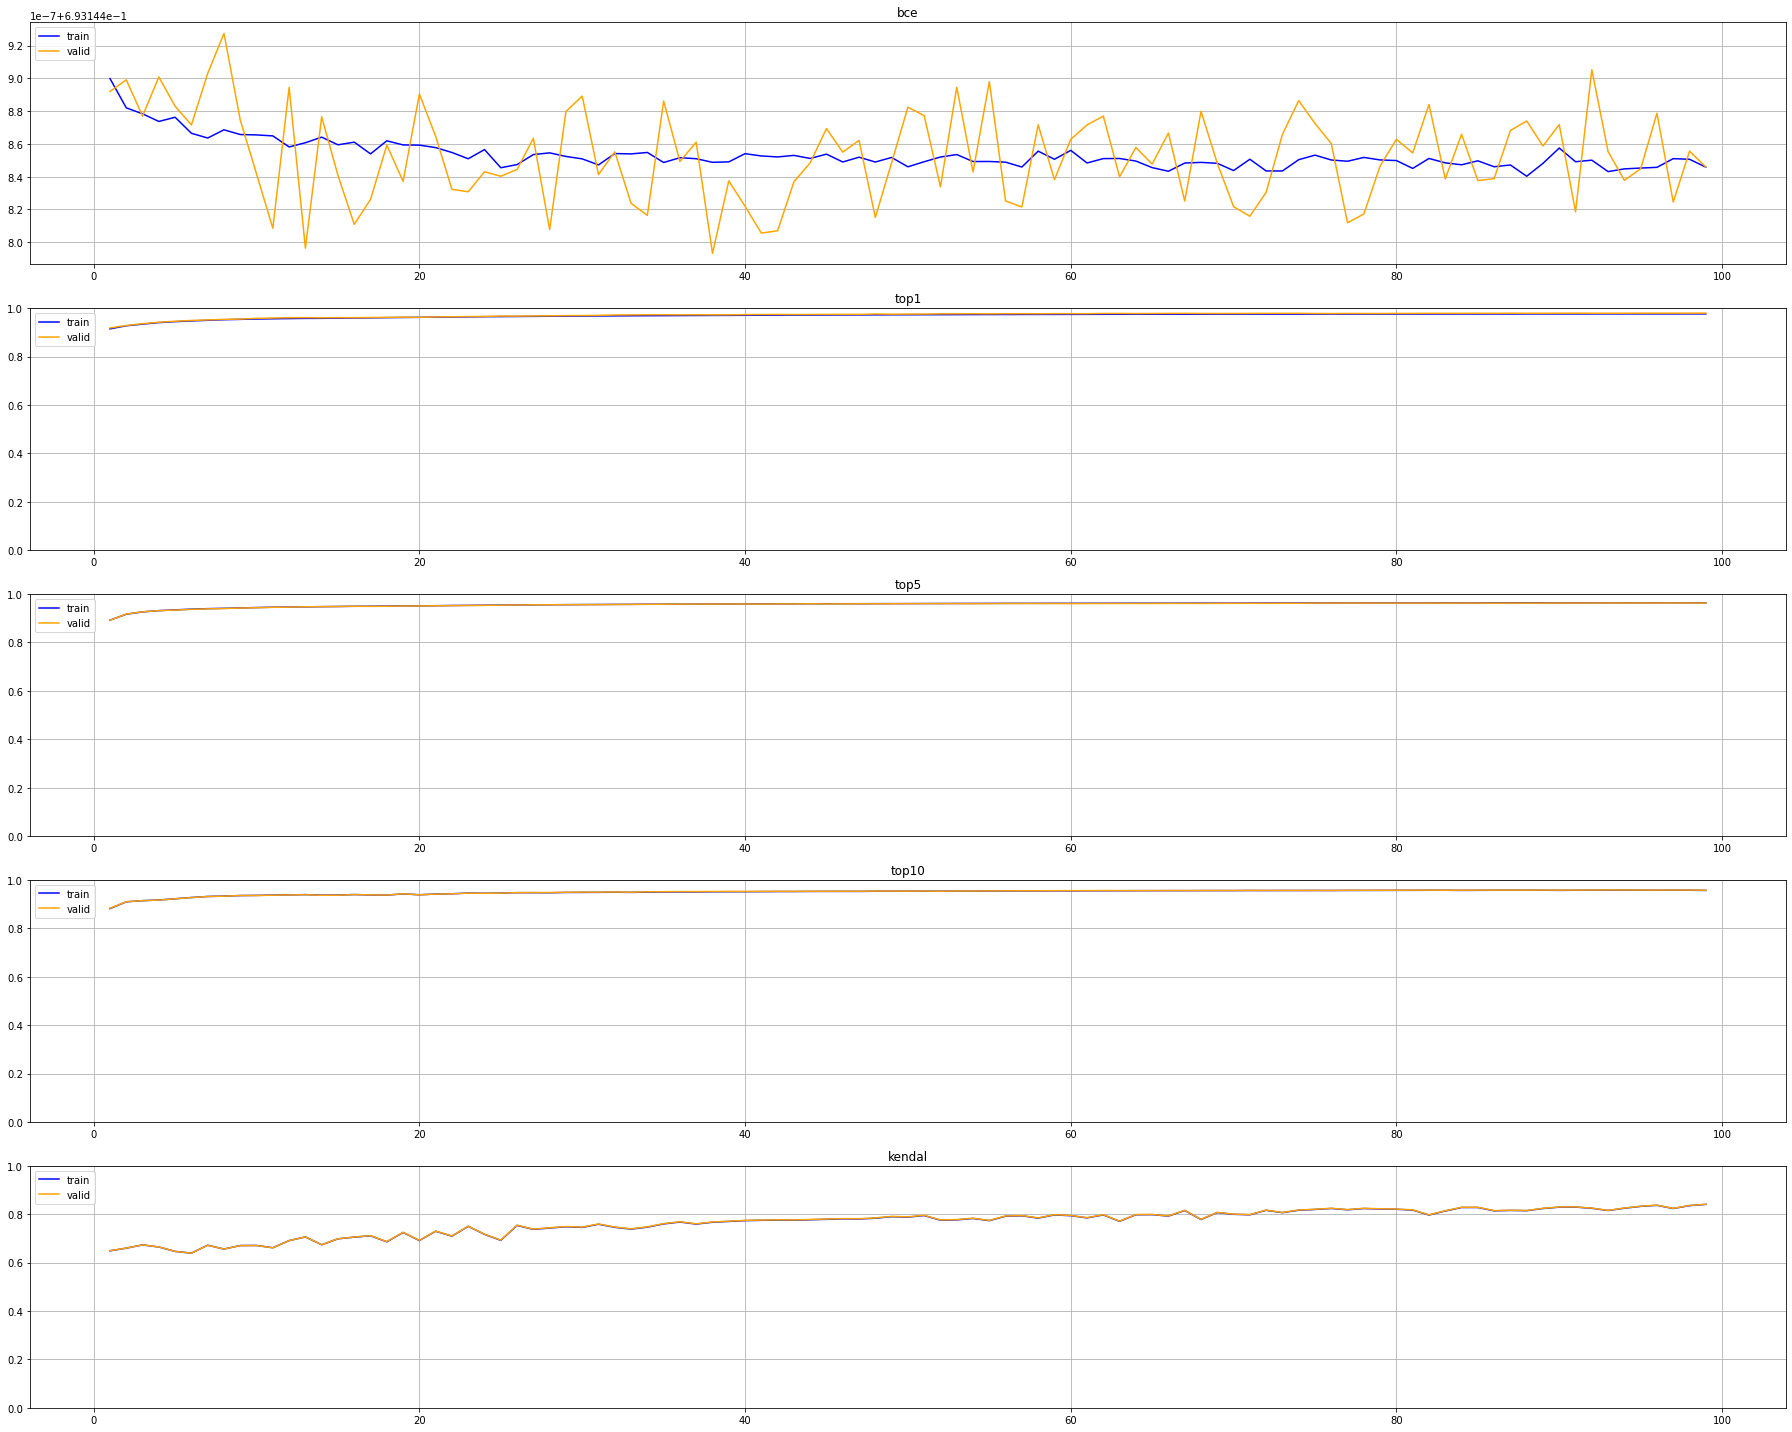

In [37]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        if key=="bce" or key=="mse":
            pass
        else:
            ax.set_ylim([0, 1])
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    